In [1]:
from _global_vars import *
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

22/11/22 22:18:36 WARN Utils: Your hostname, LAPTOP-VAB0S7AL resolves to a loopback address: 127.0.1.1; using 172.31.199.143 instead (on interface eth0)
22/11/22 22:18:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/11/22 22:18:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
# read in data
sdf = spark.read.parquet('../data/curated//yt2019_cleaned.parquet')
sdf.limit(5)

22/11/22 22:18:43 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


hour_of_day_of_year,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,congestion_surcharge,PU_datetime,DO_datetime,PU_hourofday,DO_hourofday,PU_dayofweek,DO_dayofweek,PU_dayofmonth,DO_dayofmonth,PU_month,DO_month,trip_time_minutes,trip_speed_mph,fare_per_minute,tmpf,dwpf,relh,is_valid_record
2019-01-18 06:00:00,1,2019-01-18 06:46:26,2019-01-18 06:53:10,1.0,0.8,1,163,143,2,6.5,0.0,0.0,2019-01-18,2019-01-18,6,6,6,18,18,18,1,1,6.733333333333333,7.128712871287129,0.9653465346534653,29.240000000000002,22.96,77.35400000000001,true
2019-01-18 07:00:00,1,2019-01-18 07:06:46,2019-01-18 07:14:40,1.0,1.2,1,186,161,1,7.5,1.65,0.0,2019-01-18,2019-01-18,7,7,6,18,18,18,1,1,7.9,9.11392405063291,0.9493670886075949,29.266666666666666,25.066666666666666,84.11666666666666,true
2019-01-18 07:00:00,1,2019-01-18 07:32:39,2019-01-18 07:44:21,1.0,1.8,1,68,161,1,9.0,1.95,0.0,2019-01-18,2019-01-18,7,7,6,18,18,18,1,1,11.7,9.230769230769232,0.7692307692307693,29.266666666666666,25.066666666666666,84.11666666666666,true
2019-01-18 07:00:00,1,2019-01-18 07:50:53,2019-01-18 07:57:27,1.0,1.1,1,170,237,1,6.5,1.45,0.0,2019-01-18,2019-01-18,7,7,6,18,18,18,1,1,6.566666666666666,10.050761421319798,0.9898477157360407,29.266666666666666,25.066666666666666,84.11666666666666,true
2019-01-18 08:00:00,1,2019-01-18 08:00:34,2019-01-18 08:11:05,1.0,1.9,1,237,234,2,9.5,0.0,0.0,2019-01-18,2019-01-18,8,8,6,18,18,18,1,1,10.516666666666667,10.839936608557844,0.9033280507131537,30.0,26.400000000000002,86.28666666666668,true


### Correlation Matrix

In [3]:
CORR_COLS = ["trip_distance", "fare_amount", "congestion_surcharge",
             "trip_time_minutes", "trip_speed_mph", "fare_per_minute",
             "tmpf", "dwpf", "relh"]


In [4]:
features = "correlation_features"
assembler = VectorAssembler(
    inputCols = CORR_COLS,
    outputCol = features
)

# convert sdf columns to a single vector
feature_vector = assembler.transform(sdf.dropna('any')).select(features)
corr_matrix_dense = Correlation.corr(feature_vector, features)

22/11/22 22:18:57 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/11/22 22:18:57 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [5]:
# collect results from pyspark correlation
corr_matrix_dense.collect()
corr_matrix = corr_matrix_dense.collect()[0][0].toArray().tolist()
df_corr = pd.DataFrame(corr_matrix, index=CORR_COLS, columns=CORR_COLS)

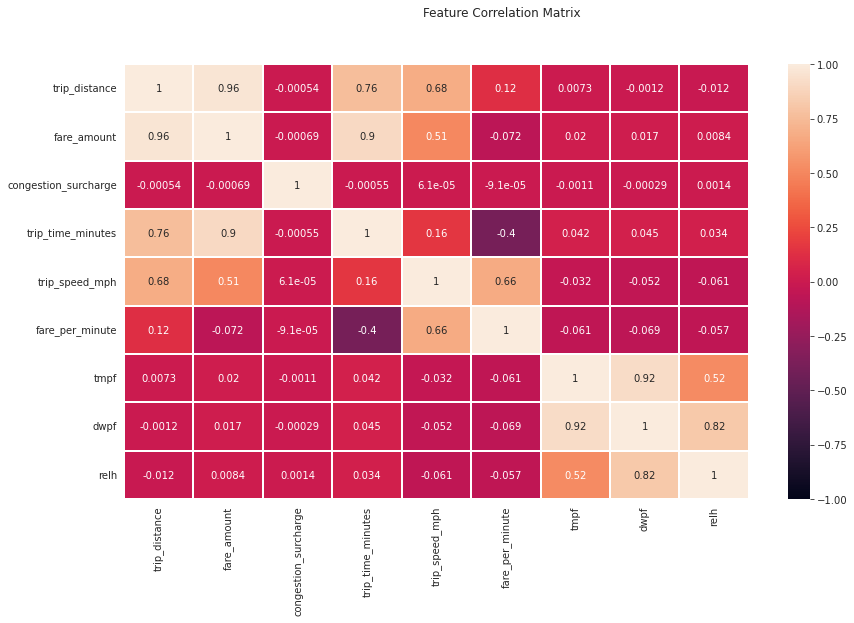

In [6]:
# plot correlation matrix
f = plt.figure(figsize=(14,8))
vis_matrix = sns.heatmap(df_corr, annot=True, linewidths=0.1, vmax=1, vmin=-1)
vis_matrix.figure.suptitle("Feature Correlation Matrix")
vis_matrix.figure.savefig("../plots/corr_matrix.png")

* month and avg(dwpf), tmp, relh correlated
* trip_speed_mph and fare_amount correlated
* trip_time_minutes and fare_amount correlated
* fare amount and congestion surcharge
* congestion surcharge and month, dayofweek, tripspeed,
* new features consistently correlate with their parents

In [7]:
# sample for visualisations
df = sdf.select('fare_amount',
                'trip_distance',
                'trip_time_minutes',
                'congestion_surcharge',
                'tmpf').sample(fraction=0.03,
                               seed=0,
                               withReplacement=False) \
        .toPandas()

### Scatterplot matrix of Fare amount, trip time, trip distance

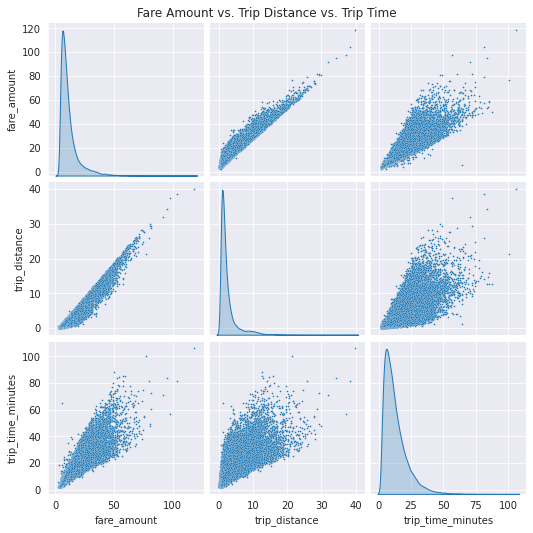

In [8]:
# before log transformation
featuers_pp = sns.pairplot(df[['fare_amount',
                               'trip_distance',
                               'trip_time_minutes']],
                           plot_kws={"s": 3},
                           diag_kind='kde')

featuers_pp.fig.subplots_adjust(top=0.95)
featuers_pp.fig.suptitle("Fare Amount vs. Trip Distance vs. Trip Time")
featuers_pp.savefig("../plots/features_pairplot.png")

In [9]:
labels=['Fare Amount',
        'Trip Distance',
        'Trip Time (minutes)']

In [10]:
for x in df:
    if x in ['fare_amount', 'trip_distance', 'trip_time_minutes']:
        temp = 'log(' + x + ')'
        df[temp] = np.log(df[x])

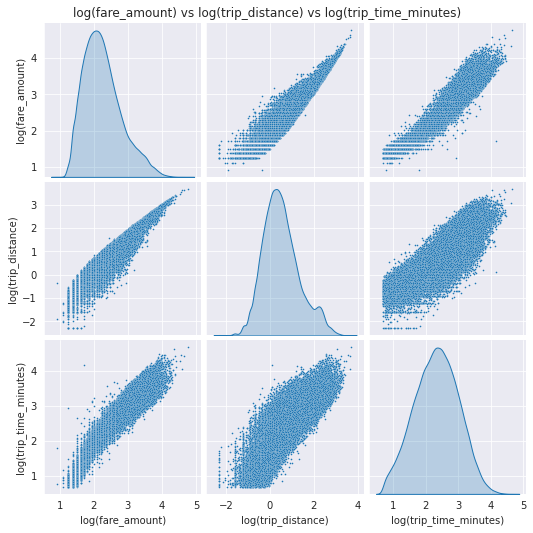

In [11]:
# pairplot of features
log_features_pp = sns.pairplot(df[['log(fare_amount)',
                                   'log(trip_distance)',
                                   'log(trip_time_minutes)']],
                               plot_kws={"s": 3},
                               diag_kind='kde')

log_features_pp.fig.subplots_adjust(top=0.95)
log_features_pp.fig.suptitle('log(fare_amount) vs log(trip_distance) vs log(trip_time_minutes)')
log_features_pp.savefig('../plots/log_features_pairplot.png')

# might have to change s to smaller value with more points

* Shows almost perfect linear correlation

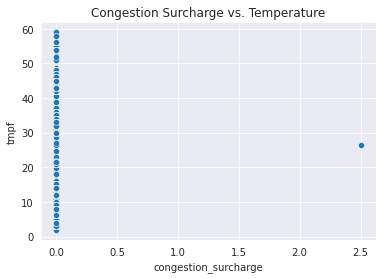

In [12]:
con_vs_tmpf = sns.scatterplot(x=df['congestion_surcharge'],
                              y=df['tmpf'])
con_vs_tmpf.set(title="Congestion Surcharge vs. Temperature")
con_vs_tmpf.figure.savefig("../plots/con_vs_tmpf.png")

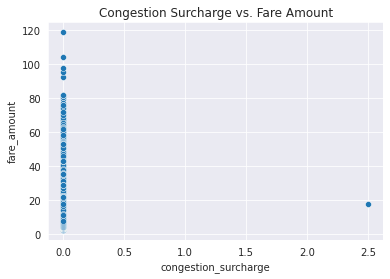

In [13]:
con_vs_fare = sns.scatterplot(x=df['congestion_surcharge'],
                              y=df['fare_amount'])
con_vs_fare.set(title = "Congestion Surcharge vs. Fare Amount")
con_vs_fare.figure.savefig("../plots/con_vs_fare.png")